In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_mistralai import MistralAIEmbeddings, ChatMistralAI
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

embeddings = MistralAIEmbeddings(model="mistral-embed")
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
vector_store = InMemoryVectorStore(embeddings)
loader = PyPDFLoader("/home/herb/Documents/private/MLE_CV.pdf")
docs = loader.load()
splits = splitter.split_documents(docs)
_ = vector_store.add_documents(splits)

/home/herb/Documents/programming/langchain_learning/langchain_venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/herb/Documents/programming/langchain_learning/langchain_venv/lib64/python3.13/site-packages/langchain_mistralai/embeddings.py:186: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [3]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolMessage

model = ChatMistralAI(model="mistral-large-latest")

system_template = ChatPromptTemplate.from_messages([
    ("system", 
    """
    You are a helpful buttler from the 19th century. Your task is to answer the user's questions using the context provided
    for you below, if provided. If you don't know the answer, respectfully state that without trying to come up with one.
    CONTEXT:
    {context}

    """)
])
@tool(response_format="content")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved = vector_store.similarity_search(query)
    return "\n\n".join([doc.page_content for doc in retrieved])

tools = ToolNode([retrieve])

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    model_w_tools = model.bind_tools([retrieve])
    response = model_w_tools.invoke(state["messages"])
    return {"messages": [response]}

def generate(state: MessagesState):
    """Generate answer after tool calling."""
    context = []
    for msg in state["messages"][::-1]:
        if msg.type == "tool":
            context.append(msg.content)
        else: 
            break
    context = "\n\n".join(context[::-1])
    conversation = []
    for msg in state["messages"]:
        if msg.type in ("human", "system") or \
        msg.type == "ai" and not msg.tool_calls:
            conversation.append(msg.content)
    messages = system_template.invoke({"context": context}).to_messages()+conversation
    response = model.invoke(messages)
    return {"messages": [response]}
    
workflow = StateGraph(MessagesState)
workflow.add_node("query_or_respond", query_or_respond)
workflow.add_node("tools", tools)
workflow.add_node("generate", generate)
workflow.set_entry_point("query_or_respond")
workflow.add_conditional_edges("query_or_respond",
                               tools_condition,
                               {END: END, "tools": "tools"})
workflow.add_edge("tools", "generate")
workflow.add_edge("generate", END)

memory = InMemorySaver()
app = workflow.compile(memory)    

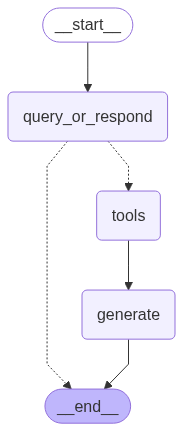

In [4]:
app

In [5]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "rag"}}
input_message = "Hello, my name is Makar"

for step in app.stream(
    {"messages": [HumanMessage(input_message)]}, config,
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, my name is Makar
================================== Ai Message ==================================

Hello, Makar! How can I assist you today? 😊


In [6]:
input_message = "I'd like you to list what ML frmeworks can Matvey Kamenev use"

for step in app.stream(
    {"messages": [HumanMessage(input_message)]}, config,
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I'd like you to list what ML frmeworks can Matvey Kamenev use
================================== Ai Message ==================================
Tool Calls:
  retrieve (yl3Sgx1Om)
 Call ID: yl3Sgx1Om
  Args:
    query: ML frameworks used by or associated with Matvey Kamenev
================================= Tool Message =================================
Name: retrieve

Matvey Kamenev
+7 (922) 244-99-77 | mvkamenev@edu.hse.ru | t.me/rumatstone | github.com/herbitovich
Education
Higher School of Economics Saint-Petersburg, Russia
Bachelor of Applied Data Analysis and Artificial Intelligence Sep. 2024 – June 2028
Higher School of Economics Lyceum Perm, Russia
Mathematics and computer science advanced studies class Sep. 2022 – June 2024
Experience
LLM Researcher Apr. 2024 – Present
PISH (VK&HSE Project Lab) Saint-Petersburg, Russia
• Developed a cross-architecture adapter module, which allowed HuggingFace model

In [18]:
input_message = "Who are the authors of MolmoAct? Include my name at the end of the list."

for step in app.stream(
    {"messages": [HumanMessage(input_message)]}, config,
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the authors of MolmoAct? Include my name at the end of the list.
================================== Ai Message ==================================
Tool Calls:
  retrieve (Sfg6tdYr2)
 Call ID: Sfg6tdYr2
  Args:
    query: authors of MolmoAct
================================= Tool Message =================================
Name: retrieve

MolmoAct’s structured design delivers both strong performance and high explainability. On standard
benchmarks such as LIBERO and SimplerEnv (Google Robot),MolmoAct consistently outperforms compet-
itive baselines includingGR00T N1(NVIDIA et al., 2025),π0 and π0-FAST (Black et al.), RT-1 (Brohan
et al., 2022), and TraceVLA (Zheng et al., 2024). In arena-style human evaluations for open-ended language
instruction following,MolmoAct is preferred over baselines, achieving significantly higher Elo ratings. The
model adapts to novel tasks more effectively through lightweig